# Fitting of TimeResolved EPR Spectra with MarS

This notebook demonstrates how to use the Mars library to fit experimental 2d-timeresolved EPR spectra by optimizing Kynetic parameters.

Mars provides integration with powerful optimization libraries (Optuna and Nevergrad) that implement various algorithms with different strengths for finding global minima in complex parameter spaces. In this notebook we will fit 2D-timeresolved spectra via MarS library. We strongly recommend you to consider Example 1 and 5 (and 3, probably) before consideration of this notebook


\
\
\
\
\
\
For any questions, please contact Arkady Samsonenko via: \
Telegram: @Arkady_Samsonenko \
Email: a.samsonenko.tomo.nsc.ru \
\
\
Last update of notebook: 2026.01.27

In [2]:
import typing as tp
import sys
import os
import math

import numpy as np
import torch
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

# Import Mars library components
import mars
from mars import spin_model, spectra_manager, mesher, constants
from mars import utils
from mars import population

from mars import visualization

In [3]:
dtype = torch.float64
device = torch.device("cpu")

# 1. Introduction.

In this notebook, we focus on a system of three photo-generated triplet states coupled via weak dipolar interactions and exchange interactions, where each triplet may be oriented differently in space.

**Workflow:**
1. Set the Hamiltonian parameters for each triplet state
2. Set the relaxation and population parameters for each system
3. Create a time-resolved fitting pipeline

### 1.1. Setting the Sample Parameters

We consider three triplet states (S = 1), each with its own g-tensor and zero-field splitting (ZFS) parameters. We set the same principal values but different orientations for these triplets. The triplets are coupled by weak intermolecular dipolar and exchange interactions.

In our consideration, the second triplet is rotated relative to the first by a fixed Euler angle set, and the third is rotated relative to the second by the same fixed Euler angle set. We call these triplets "a", "b", and "c".

**Note on Model Limitations**  
The current model only includes the triplet sublevels and neglects the singlet states that are inherently part of real photoexcited systems. A fully consistent description would require treating each chromophore as a singlet–triplet system, i.e., a two-state manifold comprising one singlet ($|S\rangle$) and three triplet ($|T\rangle$) sublevels.  

If the Hilbert space for a single unit is $|S\rangle \oplus |T\rangle$, then the total Hilbert space for three coupled units becomes the tensor product:

$$
(|S_1\rangle \oplus |T_1\rangle) \otimes (|S_2\rangle \oplus |T_2\rangle) \otimes (|S_3\rangle \oplus |T_3\rangle)
 $$

Expanding the tensor product explicitly gives all eight possible combinations:

$$
|S_1\rangle \otimes |S_2\rangle \otimes |S_3\rangle \\
+ |S_1\rangle \otimes |S_2\rangle \otimes |T_3\rangle \\
+ |S_1\rangle \otimes |T_2\rangle \otimes |S_3\rangle \\
+ |S_1\rangle \otimes |T_2\rangle \otimes |T_3\rangle \\
+ |T_1\rangle \otimes |S_2\rangle \otimes |S_3\rangle \\
+ |T_1\rangle \otimes |S_2\rangle \otimes |T_3\rangle \\
+ |T_1\rangle \otimes |T_2\rangle \otimes |S_3\rangle \\
+ |T_1\rangle \otimes |T_2\rangle \otimes |T_3\rangle
$$

In compact notation (omitting $\otimes$ for brevity, as is conventional):

$$
|S_1 S_2 S_3\rangle  \oplus  |S_1 S_2 T_3\rangle  \oplus  |S_1 T_2 S_3\rangle  \oplus  |S_1 T_2 T_3\rangle \oplus  |T_1 S_2 S_3\rangle  \oplus  |T_1 S_2 T_3\rangle  \oplus |T_1 T_2 S_3\rangle  \oplus |T_1 T_2 T_3\rangle
$$

In our current consideration we want to discuss the fitting detail rather then physical models. So< futher we will continue the relaxation only the last $|T_1 T_2 T_3\rangle$ states.

Probably, with manual actions the consideration of full system with 64 is still possible (like notification that Hamiltonian can be created as block-diagonal) but it is already the different task

In [4]:
def create_triplet_sample(
    hamiltonian_params: dict[str, tp.Any],
    frame: list[float]
) -> spin_model.MultiOrientedSample:
    """
    Construct a powder sample containing a single S=1 triplet state.
    
    Parameters
    ----------
    hamiltonian_params : dict
        Contains keys: 'g' (g-tensor principal values), 
                       'DE' (ZFS D and E parameters in Hz),
                       'gauss', 'lorentz' (line broadening in Tesla).
    frame : list[float]
        Euler angles (α, β, γ) in radians defining the orientation 
        of the molecular frame relative to the lab frame.
        
    Returns
    -------
    MultiOrientedSample
        A disordered (powder) sample ready for simulation.
    """
    
    g_tensor = spin_model.Interaction(ham_params["g"], frame=frame, device=device, dtype=dtype)
    zfs_interaction = spin_model.DEInteraction(ham_params["DE"], frame=frame, device=device, dtype=dtype)
    
    base_spin_system = spin_model.SpinSystem(
        electrons=[1.0],  # S=1
        g_tensors=[g_tensor],
        electron_electron=[(0, 0, zfs_interaction)], # ZFS on electron 0
        device=device,
        dtype=dtype
    )
    
    sample = spin_model.MultiOrientedSample(
        base_spin_system=base_spin_system,
        gauss=ham_params["gauss"],
        lorentz=ham_params["lorentz"],
        mesh = (15, 15),  # Let's reduce mesh a little bit. These values will be enough
        device=device,
        dtype=dtype,
    )
    return sample

**Alternative approach:** It is also possible to achieve the same result by using the `spin_system_frame` parameter of `MultiOrientedSample` or the `apply_rotation` method of `SpinSystem`. See the commented code below for an example:

```python
def create_triplet_sample_alternative(ham_params: dict[str, tp.Any], frame: list[float]):
    g_interaction = spin_model.Interaction(ham_params["g"], device=device, dtype=dtype)  # No frames here
    zfs_interaction = spin_model.DEInteraction(ham_params["DE"], device=device, dtype=dtype)  # No frames here
    
    base_spin_system = spin_model.SpinSystem(
        electrons=[1.0],
        g_tensors=[g_interaction],
        electron_electron=[(0, 0, zfs_interaction)],
        device=device,
        dtype=dtype
    )
    
    sample = spin_model.MultiOrientedSample(
        base_spin_system=base_spin_system,
        gauss=ham_params["gauss"],
        lorentz=ham_params["lorentz"],
        spin_system_frame=frame,  # Set the relative frame of the whole spin system
        device=device,
        dtype=dtype,
    )
    
    return sample
```

In [5]:
def create_coupled_triplets_sample(
    hamiltonian_params: dict[str, tp.Any],
    relative_euler_angles_b: list[float],
    relative_euler_angles_c: list[float]
) -> spin_model.MultiOrientedSample:
    """
    Construct a sample with two S=1 triplets coupled by a dipolar interaction.
    The second triplet is rotated by `relative_rotation` relative to the first.
    
    Parameters
    ----------
    hamiltonian_params : dict
        Must include: 'g', 'DE', 'dipolar' (D, E for inter-triplet coupling),
                      'gauss', 'lorentz'.
    relative_euler_angles_b : list[float]
        Euler angles for rotating the second triplet local frame.
        
    relative_euler_angles_c : list[float]
        Euler angles for rotating the third triplet local frame.
        
    Returns
    -------
    MultiOrientedSample
        Powder sample of two interacting triplets.
    """
    # First triplet: aligned with frame of molecule (no rotation)
    g_tensor_1 = spin_model.Interaction(ham_params["g"], frame=None, device=device, dtype=dtype)
    zfs_interaction_1 = spin_model.DEInteraction(ham_params["DE"], frame=None, device=device, dtype=dtype)
    
    # Second triplet: rotated
    g_tensor_2 = spin_model.Interaction(ham_params["g"], frame=relative_euler_angles_b, device=device, dtype=dtype) 
    zfs_interaction_2 = spin_model.DEInteraction(ham_params["DE"], frame=relative_euler_angles_b, device=device, dtype=dtype)
    
    
    # Third triplet: rotated twice
    g_tensor_3 = spin_model.Interaction(ham_params["g"], frame=relative_euler_angles_c, device=device, dtype=dtype) 
    zfs_interaction_3 = spin_model.DEInteraction(ham_params["DE"], frame=relative_euler_angles_c, device=device, dtype=dtype)
    
    
    # Dipolar and exchagne coupling between the a and b triplets
    diploar_ab = spin_model.DEInteraction(ham_params["dipolar"], device=device, dtype=dtype)
    exchange_ab = spin_model.Interaction(ham_params["exchange"], device=device, dtype=dtype)
    
    # Dipolar and exchange coupling between triplets b and c
    # Note: we set the frame of the second triplet because the b-c pair
    # is rotated relative to the a-b pair
    diploar_bc = spin_model.DEInteraction(ham_params["dipolar"],  frame=relative_euler_angles_b, device=device, dtype=dtype)
    exchange_bc = spin_model.DEInteraction(ham_params["exchange"], device=device, dtype=dtype)
    
    base_spin_system = spin_model.SpinSystem(
        electrons=[1.0, 1.0, 1.0],
        g_tensors=[g_tensor_1, g_tensor_2, g_tensor_3],
        electron_electron=[
            (0, 0, zfs_interaction_1),  # ZFS on triplet 1
            (1, 1, zfs_interaction_2),  # ZFS on triplet 2
            (2, 2, zfs_interaction_2),  # ZFS on triplet 3
            (0, 1, diploar_ab + exchange_ab),         # Inter-triplet dipolar coupling between 1 and 2
            (1, 2, diploar_bc + exchange_bc),         # Inter-triplet dipolar coupling between 2 and 3
        ],
        device=device,
        dtype=dtype
    )
    
    sample = spin_model.MultiOrientedSample(
        base_spin_system=base_spin_system,
        gauss=ham_params["gauss"],
        lorentz=ham_params["lorentz"],
        mesh = (15, 15), # Let's reduce mesh a little bit. These values will be enough
        device=device,
        dtype=dtype,
    )
    return sample

In [6]:
ham_params = {
    "g": (2.02, 1.97, 2.06),          # Anisotropic g-tensor
    "DE": (500e6, 100e6),             # ZFS: D = 500 MHz, E = 100 MHz
    "gauss": 1e-3,                    # Gaussian broadening (T)
    "lorentz": 1e-3,                  # Lorentzian broadening (T)
    "dipolar": (200e6, 40e6),         # Weak inter-triplet coupling
    "exchange": 1e8,                  # Weak exchange interaction
}


# Relative orientation of the second triplet (Euler angles in radians)
relative_euler_angles_b = (0.3, 0.3, 0.3)

# Find the relative orientation of the c-spin system relative to the a-spin system
rot_matrix = utils.euler_angles_to_matrix(relative_euler_angles_b)
rot_matrix = rot_matrix @ rot_matrix
relative_euler_angles_c = utils.rotation_matrix_to_euler_angles(rot_matrix) 

# Create individual triplet samples
triplet_a_sample = create_triplet_sample(ham_params, [0, 0, 0])
triplet_b_sample = create_triplet_sample(ham_params, relative_euler_angles_b)
triplet_c_sample = create_triplet_sample(ham_params, relative_euler_angles_c)

# Create coupled system
coupled_system_sample = create_coupled_triplets_sample(ham_params, relative_euler_angles_b, relative_euler_angles_c)

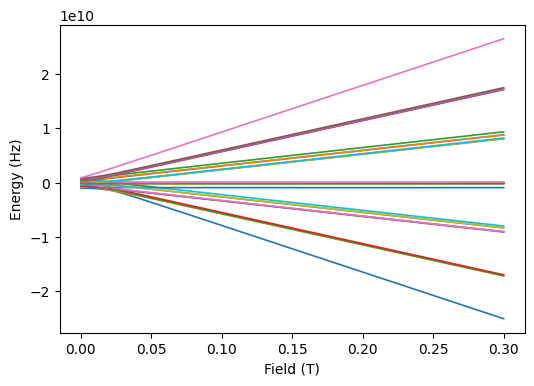

In [7]:
# Visualize the energy level system of the coupled sample
visualization.plot_energy_system(coupled_system_sample, B_range=(0.0, 0.3))

### 1.2. Relaxation Context for Time-Resolved Simulation

In time-resolved EPR, the initial spin polarization and relaxation pathways determine the observed signal evolution. We define a composite context that combines:

1. **Initial populations** in the laboratory (XYZ) basis (e.g., due to photoexcitation)
2. **Irreversible decay** (`out_probs`) from each sublevel
3. **Intrasystem transitions**: This is a more complex parameter, as there are several physical models within which this parameter can be written. For example, let's define intersystem transitions in the multiplet basis of each individual electron: T₋₁, T₀, T₊₁.

Since the triplet levels are mixed with each other, we will observe a broad distribution of transitions within the spin system of three triplets.

**MarS context algebra:**
- `+` → summation of independent relaxation mechanisms on the same system
- :def:`population.multiply_contexts` → multiply several triplet mechanisms

In [8]:
def get_context(
    initial_populations_xyz: list[float],
    triplet_a_sample: spin_model.MultiOrientedSample,
    triplet_b_sample: spin_model.MultiOrientedSample,
    triplet_c_sample: spin_model.MultiOrientedSample,
    intra_triplet_rate_scale: float = 20,
    out_rate: float = 100.0,
) -> population.Context:
    """
    Construct a composite relaxation context for three coupled triplet states.
    
    This function builds a full relaxation model for a system of three S=1 triplets,
    combining:
    - Non-Boltzmann initial spin polarization in the laboratory (XYZ) basis
    - Irreversible depopulation ("out" probabilities)
    - Internal thermalization within each triplet in the |T₋₁⟩, |T₀⟩, |T₊₁⟩ basis
    
    The resulting context can be used with time-resolved or stationary spectra
    simulators in MarS.

    Parameters
    ----------
    initial_populations_xyz : list[float]
        Initial populations in the XYZ basis for each triplet, given as
        [Tx, Ty, Tz].
        Example: [0.1, 0.3, 0.6].  X, Y, Z
        
    triplet_a_sample : MultiOrientedSample
        Spin system sample representing the first triplet state.
        
    triplet_b_sample : MultiOrientedSample
        Spin system sample representing the second triplet state
        
    triplet_c_sample : MultiOrientedSample
        Spin system sample representing the third triplet state
        
    intra_triplet_rate_scale : float, optional
        Scaling factor (in s⁻¹) for internal probabilities transition between
        sublevels within a triplet.

    out_rate : float, optional
        Irreversible depopulation rate (s⁻¹) applied equally to all three
        sublevels of both triplets
        
    Returns
    -------
    population.Context
        Composite relaxation context for the two-triplet system

    The total context is built as:
        (context_A_XYZ + context_A_multiplet) ⊗ (context_B_XYZ + context_B_multiplet) ⊗ (context_C_XYZ + context_C_multiplet)
    """

    # Irreversible depopulation rate (same for all sublevels): 100 s⁻¹ → τ ≈ 10 ms
    out_rates = [out_rate, out_rate, out_rate]  # in s⁻¹

    # Internal thermalization within each triplet (~1 ms equilibration time)
    intra_triplet_rates = torch.tensor([
        [0.0, 1.0, 0.0],   # T-1 -> T0
        [1.0, 0.0, 1.0],   # T0 -> T-1 and T0 -> T+1
        [0.0, 1.0, 0.0]    # T+1 -> T0
    ], device=device, dtype=dtype) * intra_triplet_rate_scale


    # For triplet A: initial polarization + decay in XYZ basis
    context_a_xyz = population.Context(
        sample=triplet_a_sample,
        basis="xyz",
        init_populations=initial_populations_xyz,
        out_probs=out_rates,
        device=device,
        dtype=dtype
    )

    # For triplet A: internal relaxation in multiplet basis T-1, T0, T+1
    context_a_multiplet = population.Context(
        sample=triplet_a_sample,
        basis="multiplet",
        free_probs=intra_triplet_rates,
        device=device,
        dtype=dtype
    )

    # Repeat for triplet B (identical parameters assumed)
    context_b_xyz = population.Context(
        sample=triplet_b_sample,
        basis="xyz",
        init_populations=initial_populations_xyz,
        out_probs=out_rates,
        device=device,
        dtype=dtype
    )

    context_b_multiplet = population.Context(
        sample=triplet_b_sample,
        basis="multiplet",
        free_probs=intra_triplet_rates,
        device=device,
        dtype=dtype
    )
    
    
    # Repeat for triplet C (identical parameters assumed)
    context_c_xyz = population.Context(
        sample=triplet_c_sample,
        basis="xyz",
        init_populations=initial_populations_xyz,
        out_probs=out_rates,
        device=device,
        dtype=dtype
    )

    context_c_multiplet = population.Context(
        sample=triplet_c_sample,
        basis="multiplet",
        free_probs=intra_triplet_rates,
        device=device,
        dtype=dtype
    )

    # Combine mechanisms per triplet, then form multiplied system.
    # It is better to do it manually via multiply contexts then by @ operation
    total_relaxation_context = population.multiply_contexts((
        (context_a_xyz + context_a_multiplet),
        (context_b_xyz + context_b_multiplet),
        (context_c_xyz + context_c_multiplet),
    ))
    return total_relaxation_context

### 1.3. Simulate Stationary Spectrum

Although this notebook focuses on time-resolved modeling,
it's useful to inspect the steady-state spectrum under the defined polarization:

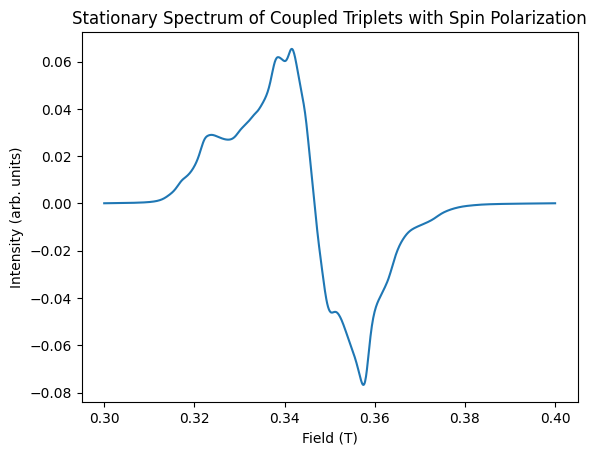

In [9]:
total_context = get_context(
    initial_populations_xyz = [0.2, 0.3, 0.5],  # Set some values. Let is be [0.2, 0.3, 0.5]
    intra_triplet_rate_scale = 20.0,
    out_rate = 100.0,
    triplet_a_sample=triplet_a_sample,
    triplet_b_sample=triplet_b_sample,
    triplet_c_sample=triplet_c_sample,
)

spectra_creator = spectra_manager.StationarySpectra(
    freq=9.8e9,    # Frequency in Hz
    sample=coupled_system_sample,
    harmonic=0,      # absorbtion
    context=total_context, 
    temperature=300.0,  # Room temperature (K)
    device=device,
    dtype=dtype
)

fields = torch.linspace(0.3, 0.4, 1000, dtype=dtype, device=device)  # Field in Tesla
spectrum = spectra_creator(coupled_system_sample, fields)

plt.plot(fields, spectrum)
plt.xlabel("Field (T)")
plt.ylabel("Intensity (arb. units)")
plt.title("Stationary Spectrum of Coupled Triplets with Spin Polarization")
plt.show()

### 1.4. Syntetic Spectra Creation

As in previous examples (notebook 3), let's generate some synthetic spectra to fit later.

**Important Note:** Unfortunately, we cannot perform a full simulation for such a system in Liouville space. The system is too large - 27 levels and approximately 100 transitions between them. Therefore, let's construct the relaxation starting at 10 µs, when the T₂ relaxation has already finished.

For `CoupledTimeSpectra`, generating one spectrum takes approximately 10-20 seconds.

In [10]:
# Set ground Truth parameters:
total_context = get_context(
    initial_populations_xyz = [0.2, 0.3, 0.5],  # Set some values. Let is be [0.2, 0.3, 0.5]
    intra_triplet_rate_scale = 20.0,
    out_rate = 100.0,
    triplet_a_sample=triplet_a_sample,
    triplet_b_sample=triplet_b_sample,
    triplet_c_sample=triplet_c_sample,
)

Generated synthetic spectrum with shape: torch.Size([100, 500])
Noise level: 5.0% of max intensity


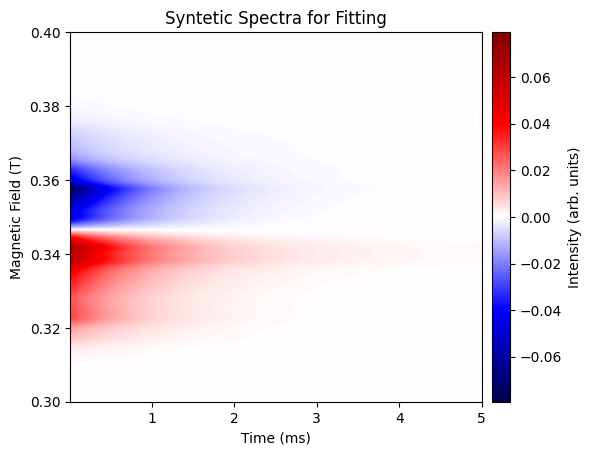

In [11]:
tr_spectra_creator = spectra_manager.CoupledTimeSpectra(
    freq=9.8  * 1e9,
    sample=coupled_system_sample,
    harmonic=0,                             # Absorption mode
    context=total_context,
    temperature=300.0,
    device=device,
    dtype=dtype
)

# Define simulation axes
fields = torch.linspace(0.30, 0.40, 500, device=device, dtype=dtype)       # Tesla
time = torch.linspace(1e-5, 0.005, 100, device=device, dtype=dtype)        # Seconds (from 10 us to 500 us)

# Simulate ground truth spectrum
spectrum_gt = tr_spectra_creator(coupled_system_sample, fields, time)

# Add experimental noise (5% Gaussian noise)
noise_level = 0.05
noise = torch.randn_like(spectrum_gt) * noise_level * spectrum_gt.abs().max()
spectrum_exp = spectrum_gt + noise

print(f"Generated synthetic spectrum with shape: {spectrum_exp.shape}")
print(f"Noise level: {noise_level*100:.1f}% of max intensity")
visualization.plot_2d_timeresolved(fields, time, spectrum_gt, time_unit="ms")
plt.title("Syntetic Spectra for Fitting")
plt.show()

# 2. Fitting Time-Resolved Spectra

In this section, we will fit the `intra_triplet_rate_scale` parameter using the synthetic time-resolved spectrum generated in section 1.

**Workflow:**
1. Define the parameter space for optimization
2. Create a 2D spectra simulator that can update the relaxation context
3. Set up the Spectrum2DFitter
4. Run optimization using Bayes Oprimizer

### 2.1. Define Parameter Space for Fitting

We will fit only the `intra_triplet_rate_scale` parameter while keeping all Hamiltonian parameters fixed. This is a common scenario in time-resolved EPR where the spin system can be already characterized but relaxation dynamics need to be determined.

In [12]:
from mars.optimization import ParameterSpace, ParamSpec, Spectrum2DFitter, print_trial_results

# Define the parameter to fit
param_specs = [
    ParamSpec(
        name="intra_triplet_rate_scale", 
        bounds=(5.0, 100.0),  # Some Reasonable range for internal relaxation rates
        default=50.0,
        vary=True
    ),
]

# Fixed parameters include parameters that we need to create context.
# We do not need to change samples or create new samples. So we do not use Hamiltonian parameters here 
param_space_fit = ParameterSpace(
    specs=param_specs,
    fixed_params={
        "out_rate": 100.0,
        "initial_populations_xyz": [0.2, 0.3, 0.5],
    }
)

print(param_space_fit)

Some stuff might fail: issue in joblib
[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.
____Fixed parameters_____ 
----------------------------------------
  out_rate                =        100.0000
  initial_populations_xyz = [0.2, 0.3, 0.5]


______Varying parameters_____ 
----------------------------------------
  intra_triplet_rate_scale =         50.0000   (low:  

### 2.2. Create Time-Resolved Spectra Simulator

The simulator must accept three arguments: `fields`, `times`, and `params`. It will create a new relaxation context based on the optimization parameters and calculate the 2D spectrum.

In [13]:
class TRSpectraSimulator:
    """
    Simulator for time-resolved EPR spectra.
    
    This simulator creates a CoupledTimeSpectra object and updates the 
    relaxation context based on the optimization parameters.
    """
    
    def __init__(
        self, 
        coupled_system_sample,
        triplet_a_sample,
        triplet_b_sample,
        triplet_c_sample,
        device,
        dtype
    ):
        self.coupled_system_sample = coupled_system_sample
        self.triplet_a_sample = triplet_a_sample
        self.triplet_b_sample = triplet_b_sample
        self.triplet_c_sample = triplet_c_sample
        
        self.spectra_manager = spectra_manager.CoupledTimeSpectra(
            freq=9.8 * 1e9,
            sample=self.coupled_system_sample,
            harmonic=0,
            context=None,  # Initialize with None. Then we will pas in forward the current context
            temperature=300.0,
            # Here we disable computation of eigen parameters since we can compute it only for the first iteration and cach them.
            recompute_spin_parameters = False,  
            device=device,
            dtype=dtype
        )
        
        self.device = device
        self.dtype = dtype
        
    def __call__(self, fields, times, params):
        """
        Generate 2D time-resolved spectrum for given parameters.
        
        Parameters
        ----------
        fields : torch.Tensor
            Magnetic field values (T)
        times : torch.Tensor
            Time values (s)
        params : dict
            Parameter dictionary containing context parameters
            
        Returns
        -------
        spectrum_2d : torch.Tensor
            2D spectrum with shape (len(times), len(fields))
        """
        # Create context with updated relaxation parameters
        context = get_context(
            initial_populations_xyz=params["initial_populations_xyz"],
            triplet_a_sample=self.triplet_a_sample,
            triplet_b_sample=self.triplet_b_sample,
            triplet_c_sample=self.triplet_c_sample,
            intra_triplet_rate_scale=params["intra_triplet_rate_scale"],
            out_rate=params["out_rate"],
        )
        
        # Create time-resolved spectra calculator
        self.spectra_manager.update_context(context)
        
        # Calculate and return 2D spectrum
        spectrum = self.spectra_manager(self.coupled_system_sample, fields, times)
        return spectrum

### 2.3. Initialize the 2D Spectrum Fitter

Now we create the `Spectrum2DFitter` object. This is the 2D analog of `SpectrumFitter` used in Example 3.

In [ ]:
# Create the simulator instance
tr_simulator = TRSpectraSimulator(
    coupled_system_sample=coupled_system_sample,
    triplet_a_sample=triplet_a_sample,
    triplet_b_sample=triplet_b_sample,
    triplet_c_sample=triplet_c_sample,
    device=device,
    dtype=dtype
)

# Create the 2D fitter
fitter_2d = Spectrum2DFitter(
    x1_exp=fields,           # Magnetic field axis (T)
    x2_exp=time,             # Time axis (s)
    y_exp=spectrum_exp,      # 2D experimental data (with noise)
    param_space=param_space_fit,
    spectra_simulator=tr_simulator,
    norm_mode="max",         # Normalize by maximum intensity
    device=device
)

### 2.4. Fitting with Optuna_integration

In this section, we explore an advanced optimization strategy using optuna-integration (https://optuna-integration.readthedocs.io/en/stable/reference/index.html) - an extension of the standard Optuna library that provides access to state-of-the-art samplers from external frameworks.

One particularly option is the BoTorchSampler, which leverages Bayesian optimization via the BoTorch library (a probabilistic modeling and optimization framework built on PyTorch). Bayesian optimization is well-suited for expensive-to-evaluate objective functions, such as our case.

Key advantages in our context:

1) Efficient global optimization:
Bayesian optimization builds a probabilistic surrogate model of the objective function and uses it to intelligently select the next set of parameters to evaluate. This often leads to faster convergence to high-quality minima compared to traditional methods.

2) Computational overhead:
A single Bayesian optimization step typically takes ~1 second. Given that each spectral simulation in our workflow requires 5–20 seconds, this additional cost is minimal and well justified by the potential gains in sample efficiency.

In [15]:
import optuna_integration

In [15]:
sampler = optuna_integration.BoTorchSampler()

result_botorch = fitter_2d.fit(
    backend="optuna",
    n_trials=100,
    sampler=sampler
)

In [26]:
rate_botorch = result_botorch.best_params["intra_triplet_rate_scale"]
best_fit = result_botorch.best_spectrum

C:\Users\User\AppData\Local\Temp\ipykernel_19436\1770759704.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


Text(0.5, 1.0, 'botorch Fit (rate_scale = 21.67)')

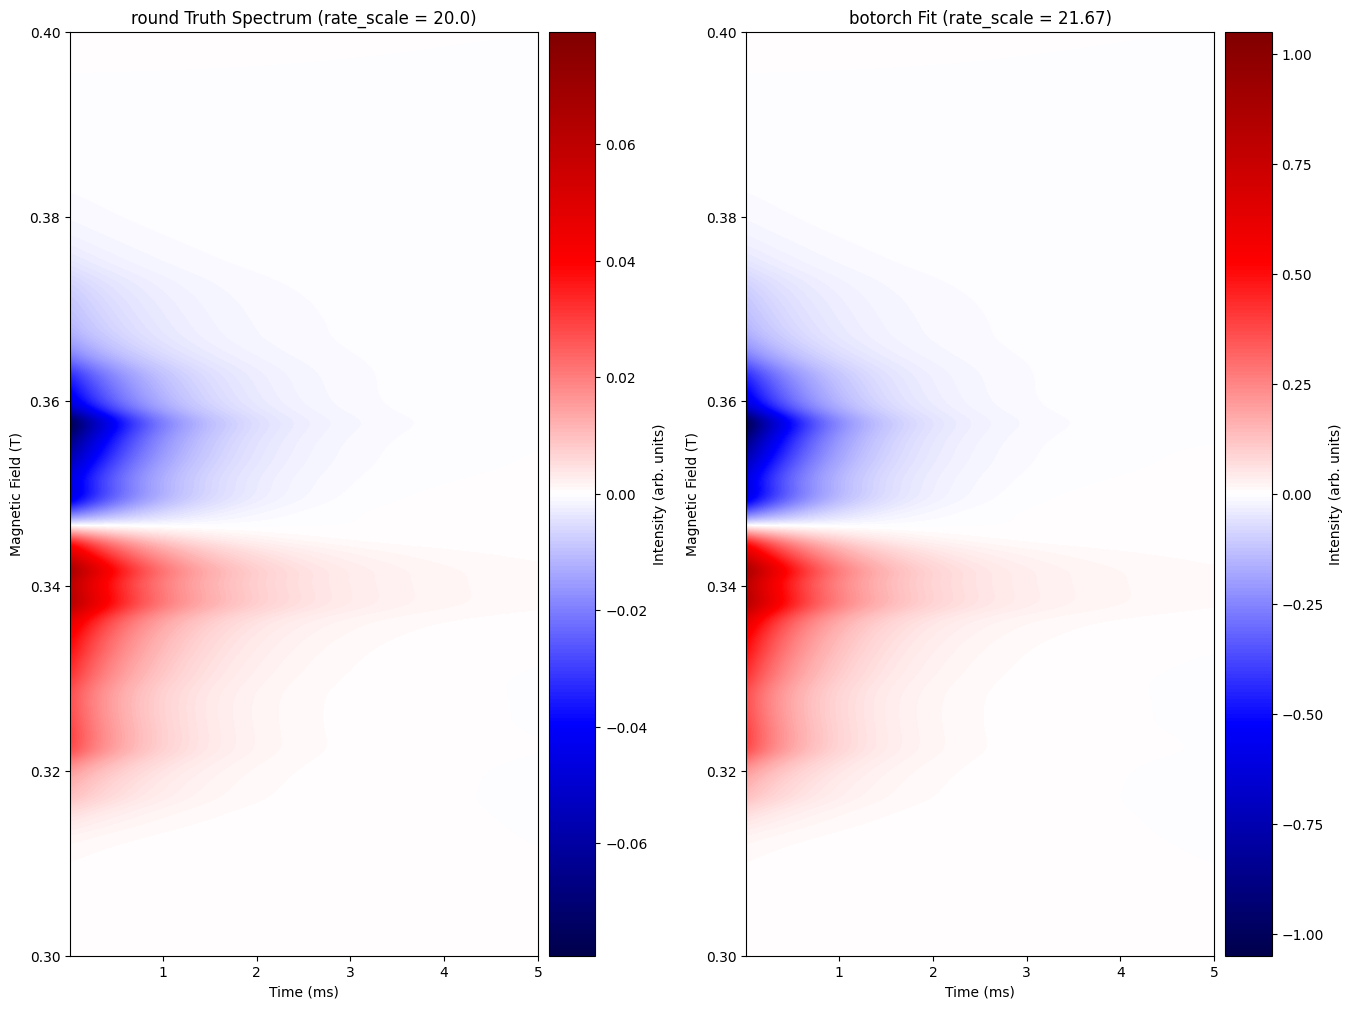

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Ground truth
plt.subplot(1, 2, 1)
visualization.plot_2d_timeresolved(fields, time, spectrum_gt, time_unit="ms")
plt.title("round Truth Spectrum (rate_scale = 20.0)")

# Plot 2: BoTorch fit
plt.subplot(1, 2, 2)
visualization.plot_2d_timeresolved(fields, time, best_fit, time_unit="ms")
plt.title(f"botorch Fit (rate_scale = {rate_botorch:.2f})")
